### Fine-tuning a Seq2Seq model (T5) in Colab with limited RAM, PyTorch version



In [1]:
!pip install transformers
!pip install accelerate -U
!pip install sentencepiece
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.5 MB/s eta 0:00:00


In [2]:
import os
import re
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import torch
import transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration, TFT5ForConditionalGeneration
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

**Data**



In [3]:
# This cell will authenticate you and mount your Drive in the Colab.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**DATA PROCESS lfqa Support Docs**

In [4]:
from datasets import load_dataset, Dataset, DatasetDict, load_metric

In [5]:
lfqa_data = load_dataset("vblagoje/lfqa_support_docs", split='train+validation').shuffle(seed=42)
lfqa_data = lfqa_data.train_test_split(test_size=0.2)
lfqa_data_val = lfqa_data['test'].train_test_split(test_size=0.5)

lfqa_docs = DatasetDict({
    'train': lfqa_data['train'],
    'test': lfqa_data_val['test'],
    'validation': lfqa_data_val['train']})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [6]:
def flatten_output(example):
  answers = []
  context = []

  for ans in example['output'][:-1]:
      answers.append(" "+str(ans['answer']).replace("\n\n",""))

  for cont in example['output'][-1]['provenance']:
    context.append(" "+str(cont['text']).replace("\n\n","").replace("\n'",""))

  return {'question': example['input'], 'context': context, 'answers': answers}

def create_input_text(example):
  return {'orig':"question: {} context: {}".format(example['question'],' '.join(example['context'])),'target':"answer: {}".format(' '.join(example['answers']))}


In [7]:
lfqa_dataset_original = lfqa_docs.map(flatten_output, remove_columns=['input','output','meta'])

Map:   0%|          | 0/183333 [00:00<?, ? examples/s]

Map:   0%|          | 0/22917 [00:00<?, ? examples/s]

Map:   0%|          | 0/22917 [00:00<?, ? examples/s]

In [8]:
lfqa_dataset_original['train']

Dataset({
    features: ['id', 'question', 'context', 'answers'],
    num_rows: 183333
})

In [9]:
lfqa_dataset_original_df = lfqa_dataset_original['train'].to_pandas()

In [10]:
lfqa_dataset_original_df

,id,question,context,answers
0,19zssz,why is there a waiting list for digital book d...,"[ Each month, four to six as-yet unpublished w...",[ Publishing companies don't like the idea of ...
1,1ryvts,Is it possible to build a computer with no ope...,"[ It is, however, still possible to encounter ...",[ It depends a lot on what you consider to be ...
2,kodr8,"Addiction: When getting off drugs, would using...",[ Drug addiction is also an example of attenti...,"[ You need to understand up regulation, down r..."
3,4jwmwz,why does red on a blue background or vice vers...,"[ Conjunctivitis, also known as pink eye, is i...","[ it hurts ours eyes? , Certain high contrast..."
4,1hqe1l,Feudalism was arguably a logistical disadvanta...,[ Battles of the Middle Ages were often smalle...,[ I'd just like to point out that while a diff...
...,...,...,...,...
183328,4o4bb8,"republican/democratic national convention, and...",[ The 2012 Republican presidential primaries w...,[ I'll give it a stab: \n \n**1) What happen...
183329,z1508,why do we still have republican/democrat natio...,[ Many American commentators have decried the ...,[ The three days of dominating press coverage ...
183330,7f1w31,how did presidential elections work before the...,"[ Starting in 2003, DISA managed the six-year,...","[ In the US, this is one of the reasons why th..."
183331,2m6ev5,Why does liquid nitrogen boil twice?,[ Liquid nitrogen is a cryogenic fluid that ca...,[ I'm not sure I fully understand how you are ...


In [11]:
# lfqa_docs = load_dataset("vblagoje/lfqa_support_docs")
# lfqa_dataset = lfqa_docs.map(flatten_output, remove_columns=['input','output','meta'])
lfqa_dataset = lfqa_dataset_original.map(create_input_text, remove_columns=['question','context','answers'])
lfqa_dataset['train'].features

Map:   0%|          | 0/183333 [00:00<?, ? examples/s]

Map:   0%|          | 0/22917 [00:00<?, ? examples/s]

Map:   0%|          | 0/22917 [00:00<?, ? examples/s]

{'id': Value(dtype='string', id=None),
 'orig': Value(dtype='string', id=None),
 'target': Value(dtype='string', id=None)}

In [12]:
train_df = lfqa_dataset['train'].to_pandas()

In [13]:
test_df = lfqa_dataset['test'].to_pandas()

In [14]:
valid_df = lfqa_dataset['validation'].to_pandas()

In [15]:
train_df

,id,orig,target
0,19zssz,question: why is there a waiting list for digi...,answer: Publishing companies don't like the i...
1,1ryvts,question: Is it possible to build a computer w...,answer: It depends a lot on what you consider...
2,kodr8,"question: Addiction: When getting off drugs, w...","answer: You need to understand up regulation,..."
3,4jwmwz,question: why does red on a blue background or...,answer: it hurts ours eyes? Certain high co...
4,1hqe1l,question: Feudalism was arguably a logistical ...,answer: I'd just like to point out that while...
...,...,...,...
183328,4o4bb8,question: republican/democratic national conve...,answer: I'll give it a stab: \n \n**1) What...
183329,z1508,question: why do we still have republican/demo...,answer: The three days of dominating press co...
183330,7f1w31,question: how did presidential elections work ...,"answer: In the US, this is one of the reasons..."
183331,2m6ev5,question: Why does liquid nitrogen boil twice?...,answer: I'm not sure I fully understand how y...


**DATA PROCESS lfqa**

In [16]:
## load lfqa data
lfqa_data_1 = load_dataset("vblagoje/lfqa")
lfqa_data_1 = lfqa_data_1.flatten()


## convert to pandas
train_df_1 = pd.DataFrame(lfqa_data_1['train'])
test_df_1 = pd.DataFrame(lfqa_data_1['test'])
valid_df_1 = pd.DataFrame(lfqa_data_1['validation'])


## extract questions & answers
# train set
train_df_1['question'] = train_df_1['title']
train_df_1['answer'] = train_df_1['answers.text'].apply(lambda x: " ".join(x))
# test set
test_df_1['question'] = test_df_1['title']
test_df_1['answer'] = test_df_1['answers.text'].apply(lambda x: " ".join(x))
# validation set
valid_df_1['question'] = valid_df_1['title']
valid_df_1['answer'] = valid_df_1['answers.text'].apply(lambda x: " ".join(x))


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [17]:
# Assuming train_df_1 is your DataFrame
train_df_1 = train_df_1.rename(columns={'q_id': 'id'})


In [18]:
import pandas as pd

# Assuming train_df_1 and lfqa_dataset_original_df are your DataFrames
# and 'id' is the common column on which you want to merge

merged_df = pd.merge(train_df_1, lfqa_dataset_original_df, on='id', how='inner')


In [19]:
training_data = merged_df.sample(frac=0.9, random_state=43)[['question_x', 'answer', 'context']]

In [20]:
merged_df.shape

(180897, 17)

In [21]:
training_data.columns

Index(['question_x', 'answer', 'context'], dtype='object')

In [22]:
merged_df['Ans_length'] = merged_df['answer'].apply(len)

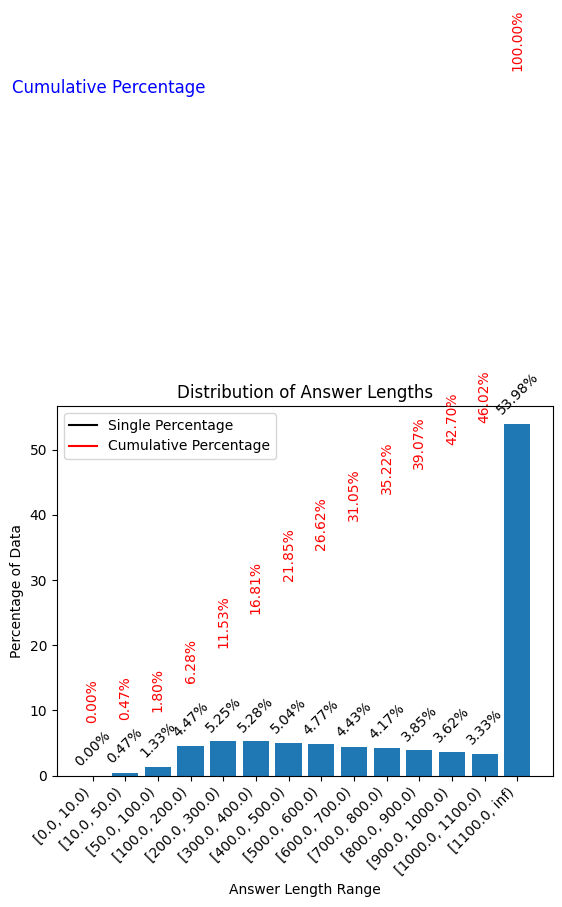

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'gold_answer_length' is the column containing answer lengths in test_df_new
bins = [0, 10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, float('inf')]  # Define the bins

# Use pd.cut() to categorize data into bins
merged_df['length_range'] = pd.cut(merged_df['Ans_length'], bins=bins, right=False)

# Calculate the percentage of data in each bin
length_range_percentages = (merged_df['length_range'].value_counts(normalize=True) * 100).sort_index()

# Plot the histogram
bars = plt.bar(length_range_percentages.index.astype(str), length_range_percentages, width=0.8)  # Adjust width as needed
plt.xlabel('Answer Length Range')
plt.ylabel('Percentage of Data')
plt.title('Distribution of Answer Lengths')

# Rotate y-axis labels at a 45-degree angle
plt.xticks(rotation=45, ha='right')  # 'ha' stands for horizontal alignment

# Add percentage labels on top of each bar with a 45-degree angle rotation
for i, value in enumerate(length_range_percentages):
    plt.text(i, value + 1, f'{value:.2f}%', ha='center', va='bottom', rotation=45)

# Calculate cumulative percentage values
cumulative_percentages = length_range_percentages.cumsum()

# Add cumulative percentage labels near the title
plt.text(0.5, 104, 'Cumulative Percentage', ha='center', va='bottom', fontsize=12, color='blue')

# Add cumulative percentage labels at a gap from individual percentage labels and at a 180-degree angle
for i, value in enumerate(cumulative_percentages):
    plt.text(i, value + 8, f'{value:.2f}%', ha='center', rotation=90, va='bottom', color='red')

# Add legend
plt.legend(handles=[plt.Line2D([0], [0], color='black', label='Single Percentage'),
                    plt.Line2D([0], [0], color='red', label='Cumulative Percentage')],
           loc='upper left')

plt.show()


In [24]:
filtered_df = merged_df[(merged_df['Ans_length'] >= 400) & (merged_df['Ans_length'] <= 500)]
filtered_df

,id,title,selftext,document,subreddit,url,answers.a_id,answers.score,answers.text,title_urls,selftext_urls,answers_urls,question_x,answer,question_y,context,answers,Ans_length,length_range
8,3lv8jv,"what causes ""flashing lights"", or blurry visio...",Had this happen to my younger brother. My par...,,explainlikeimfive,https://www.reddit.com/r/explainlikeimfive/com...,[cv9l5or],[2],"[**NOTE**: I am not a medical doctor, and this...",[],[],[[]],"what causes ""flashing lights"", or blurry visio...","**NOTE**: I am not a medical doctor, and this ...","what causes ""flashing lights"", or blurry visio...","[ In some epileptics, flickering or flashing l...","[ **NOTE**: I am not a medical doctor, and thi...",415,"[400.0, 500.0)"
9,272ed8,how do i know that i don't have depth perception?,Could I lack depth perception and just not kno...,,explainlikeimfive,http://www.reddit.com/r/explainlikeimfive/comm...,[chwv0xm],[2],"[Sure, if you've never experienced true binocu...",[],[],[[]],how do i know that i don't have depth perception?,"Sure, if you've never experienced true binocul...",how do i know that i don't have depth perception?,[ Depth perception is the visual ability to pe...,"[ Sure, if you've never experienced true binoc...",469,"[400.0, 500.0)"
52,2zrmeb,"with plea bargaining, why is it not acceptable...",,,explainlikeimfive,http://www.reddit.com/r/explainlikeimfive/comm...,[cplntdz],[11],[Because the lawyer can tell you what are and ...,[],[],[[]],"with plea bargaining, why is it not acceptable...",Because the lawyer can tell you what are and a...,"with plea bargaining, why is it not acceptable...",[ Some legal scholars argue that plea bargaini...,[ Because the lawyer can tell you what are and...,423,"[400.0, 500.0)"
68,2p3hvc,"how does face paint, such as that used by quar...",,,explainlikeimfive,http://www.reddit.com/r/explainlikeimfive/comm...,[cmszkzg],[6],"[It doesn't exactly ""block"" anything.\n\nWhat ...",[],[],[[]],"how does face paint, such as that used by quar...","It doesn't exactly ""block"" anything.\n\nWhat i...","how does face paint, such as that used by quar...",[ Mike Silver of NFL.com reported that on the ...,"[ It doesn't exactly ""block"" anything.What it ...",443,"[400.0, 500.0)"
73,1cl5w6,ruby ridge incident.,I genuinely enjoy reading interesting things t...,,explainlikeimfive,http://www.reddit.com/r/explainlikeimfive/comm...,[c9houem],[2],[Do you have a specific question? \n\nIf not I...,[],[],[[http://en.wikipedia.org/wiki/Ruby_Ridge]],ruby ridge incident.,Do you have a specific question? \n\nIf not I ...,ruby ridge incident.,[ Ruby Ridge was the site of an 11-day siege n...,[ Do you have a specific question? If not I wo...,439,"[400.0, 500.0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180820,742kfp,why is happening psychologically in a murder s...,,,explainlikeimfive,https://www.reddit.com/r/explainlikeimfive/com...,"[dnuz27j, dnv2b59]","[10, 3]",[Typically such a person believes he has been ...,[],[],[[https://www.psychologytoday.com/blog/saving-...,why is happening psychologically in a murder s...,Typically such a person believes he has been t...,why is happening psychologically in a murder s...,[ A murder–suicide is an act in which an indiv...,[ Typically such a person believes he has been...,408,"[400.0, 500.0)"
180828,6fffyj,why do some substances stain certain types of ...,,,explainlikeimfive,https://www.reddit.com/r/explainlikeimfive/com...,"[dihpwk4, dihq2iv]","[3, 3]",[It's an inverse relationship - the less you w...,[],[],"[[], [https://www.teachersource.com/product/92...",why do some substances stain certain types of ...,It's an inverse relationship - the less you wa...,why do some substances stain certain types of ...,[ A stain is a discoloration that can be clear...,[ It's an inverse relationship - the less you ...,404,"[400.0, 500.0)"
180875,2pyidn,why would anyone want to limit or reduce the f...,We are in the middle of some very heavy enviro...,,expl

In [25]:
min(filtered_df['Ans_length'])

400

**Formatting input**

In [26]:
def create_input_text(example):
  return {'orig':"question: {} context: {}".format(example['question_x'],'<s>'.join(example['context'])),'target':"answer: {}".format(' '.join(example['answer']))}


In [27]:
import pandas as pd

# Assuming training_data is your DataFrame

# Function definition
def create_input_text(example):
    return {'orig': "question: {} context: {}".format(example['question_x'], ''.join(example['context'])),
            'target': "answer: {}".format((example['answer']))}

# Apply the function to each row in the DataFrame
results = training_data[0:1].apply(create_input_text, axis=1)

# Display the results
print(results[0:1])



178206    {'orig': 'question: What was the Cuban side of...
dtype: object


In [28]:
# Create an empty list to store results
results_list = []

# Loop through each row in the DataFrame
for index, row in training_data.iterrows():
    result = create_input_text(row)
    results_list.append(result)

# Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(results_list)

# Display the results DataFrame
results_df.head()

,orig,target
0,question: What was the Cuban side of the Missi...,answer: Leading up to the Cuban Missile Crisis...
1,question: How were the Mafias and Cartels conn...,answer: Obligatory Mob references: *The Five F...
2,"question: what are functions and methods, and ...","answer: Do you know what objects are? If not,..."
3,question: what is the chemical reason people r...,answer: There's a lot of addictive substances ...
4,question: why do i occasionally (in a wakeful ...,answer: _URL_0_\n\nThe most common cause is an...


In [29]:
from sklearn.model_selection import train_test_split

# Assuming results_df is your DataFrame

# Split the DataFrame into training, validation, and test sets
train_df_new, temp_df = train_test_split(results_df, test_size=0.4, random_state=42)
val_df_new, test_df_new = train_test_split(temp_df, test_size=0.5, random_state=42)

# Display the shapes of the resulting DataFrames
print("Training DataFrame shape:", train_df_new.shape)
print("Validation DataFrame shape:", val_df_new.shape)
print("Test DataFrame shape:", test_df_new.shape)


Training DataFrame shape: (97684, 2)
Validation DataFrame shape: (32561, 2)
Test DataFrame shape: (32562, 2)


In [30]:
train_df_new.to_csv('train_df_new.csv')

In [31]:
val_df_new.to_csv('val_df_new.csv')

In [32]:
test_df_new.to_csv('test_df_new.csv')

In [33]:
# Save splits to separate csv files, to load only part at a time later
train_file = 'train_df_new.csv'
valid_file = 'val_df_new.csv'
test_file = 'test_df_new.csv'

In [34]:
#  dataset

# good one
train_pairs = []

for i in train_df_new.index:

  #print(i)
   orig, target = train_df_new['orig'][i] , train_df_new['target'][i]
   train_pairs.append({'orig': orig , 'target': target  })

In [35]:
#  dataset

# good one
valid_pairs = []

for i in val_df_new.index:

  #print(i)
   orig, target = val_df_new['orig'][i] , val_df_new['target'][i]
   valid_pairs.append({'orig': orig , 'target': target  })

### Preprocessor and Data Iterator



In [36]:
def preprocess_data(text_pair, tokenizer, max_length=400):
    orig_text, target_text = text_pair
    orig_encoded = tokenizer.batch_encode_plus(
        [orig_text],
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    orig_input_ids = orig_encoded['input_ids'][0]
    orig_attention_mask = orig_encoded['attention_mask'][0]

    target_encoded = tokenizer.batch_encode_plus(
        [target_text],
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    label_ids = target_encoded['input_ids'][0]

    return {'input_ids': orig_input_ids,
            'attention_mask': orig_attention_mask,
            'labels': label_ids}

In [37]:
class TranslationDataIterator:

    def __init__(self,
                 tokenizer,
                 n_examples,
                 max_load_at_once,
                 data_filename,
                 max_length=128,
                 shuffle=True):

        self.tokenizer = tokenizer
        self.n_examples = n_examples
        self.max_load_at_once = max_load_at_once
        self.data_filename = data_filename
        self.max_length = max_length
        self.shuffle = shuffle

        # Initialize row order, call on_epoch_end to shuffle row indices
        self.row_order = np.arange(1, self.n_examples+1)
        self.on_epoch_end()

        # Load first chunk of max_load_at_once examples
        self.df_curr_loaded = self._load_next_chunk(0)
        self.curr_idx_in_load = 0

    def _load_next_chunk(self, idx):
        load_start = idx
        load_end = idx + self.max_load_at_once

        # Indices to skip are the ones in the shuffled row_order before and
        # after the chunk we'll use for this chunk
        load_idx_skip = self.row_order[:load_start] + self.row_order[load_end:]
        self.df_curr_loaded = pd.read_csv(self.data_filename, skiprows=load_idx_skip)
        self.df_curr_loaded = self.df_curr_loaded.sample(frac=1)

    def __len__(self):
        return self.n_examples

    def __getitem__(self, idx):
        if self.df_curr_loaded is None or self.curr_idx_in_load >= len(self.df_curr_loaded):
            self._load_next_chunk(idx)
            self.curr_idx_in_load = 0

        text_pair = self.df_curr_loaded[['orig', 'target']].values.astype(str)[self.curr_idx_in_load]
        self.curr_idx_in_load += 1

        item_data = preprocess_data(
            text_pair,
            self.tokenizer,
            self.max_length
        )

        return item_data

    def __call__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)

            if i == self.__len__()-1:
                self.on_epoch_end()

    def on_epoch_end(self):
        if self.shuffle:
            self.row_order = list(np.random.permutation(self.row_order))

In [38]:
# Download tokenizer and model

model_name = 't5-base'
t5_tokenizer = T5Tokenizer.from_pretrained(model_name)
t5_model = T5ForConditionalGeneration.from_pretrained(model_name)

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [39]:
# Create the data iterators for train and validation data, pytorch version

max_length = 400
max_load_at_once = 5

train_data_iterator = TranslationDataIterator(
    tokenizer=t5_tokenizer,
    n_examples=len(train_pairs),
    # n_examples= 300 ,
    max_load_at_once=max_load_at_once,
    data_filename=train_file,
    max_length=max_length
)

valid_data_iterator = TranslationDataIterator(
    tokenizer=t5_tokenizer,
    n_examples=len(valid_pairs),
    # n_examples= 300,
    max_load_at_once=max_load_at_once,
    data_filename=valid_file,
    max_length=max_length
)

In [40]:
# Specify batch size and other training arguments

batch_size = 5

# Modify this filepath to where you want to save the model after fine-tuning
dir_path = 'content/drive/'
file_path = dir_path + 't5base-finetuned_SecondModel'

args = Seq2SeqTrainingArguments(
    file_path,
    evaluation_strategy='epoch',
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
)

In [41]:
# Define the trainer, passing in the model, training args, and data generators

trainer = Seq2SeqTrainer(
    t5_model,
    args,
    train_dataset=train_data_iterator,
    eval_dataset=valid_data_iterator
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


**Load the trained model**

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, TFT5ForConditionalGeneration

In [ ]:
model_path = '/content/drive/MyDrive/W266_Project/2ndModel-450Context'

In [ ]:
model = T5ForConditionalGeneration.from_pretrained(model_path)

In [ ]:
## output_dir = "./drive/MyDrive/My"
## model.save_pretrained(output_dir)

In [ ]:
# This cell will authenticate you and mount your Drive in the Colab.
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install sentencepiece

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')

In [ ]:
!pip install -q evaluate
!pip install -q rouge-score
!pip install rouge

from rouge import Rouge
# Now you can use the Rouge module and its functions
rouge = Rouge()
!pip install rouge-score
import evaluate
rouge = evaluate.load('rouge')

In [ ]:
# Cosine similarity for [0:3] records
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

# Initialize lists to store Rouge scores and cosine similarity scores
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []
rougeLsum_scores = []
cosine_similarity_scores = []

# Iterate through each row in the test DataFrame
for index, row in test_df_new[0:3].iterrows():

    query_and_docs = row['orig']

    # Tokenize and generate output
    encoded_query = tokenizer(query_and_docs, truncation=True, padding=True, return_tensors="pt")
    test_output_ids = model.generate(encoded_query['input_ids'])

    # Decode the generated output
    prediction = tokenizer.decode(test_output_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=False)

    # Compute Rouge scores
    rouge_scores = rouge.compute(predictions=[prediction], references=[row['target']])

    # Append the Rouge scores to the lists
    test_df_new.at[index, 'prediction'] = prediction
    test_df_new.at[index, 'rouge1_scores'] = rouge_scores['rouge1']
    test_df_new.at[index, 'rouge2_scores'] = rouge_scores['rouge2']
    test_df_new.at[index, 'rougeL_scores'] = rouge_scores['rougeL']
    test_df_new.at[index, 'rougeLsum_scores'] = rouge_scores['rougeLsum']

    # Calculate cosine similarity between 'target' and 'prediction'
    vectorizer = CountVectorizer().fit([row['target'], prediction])
    X = vectorizer.transform([row['target'], prediction])
    cosine_similarity_score = cosine_similarity(X)[0, 1]
    test_df_new.at[index, 'cosine_similarity_score'] = cosine_similarity_score

    question = row['orig'].split('context:')[0].strip()
    test_df_new.at[index, 'question'] = question

    answer_length = len(row['target'])
    test_df_new.at[index, 'gold_answer_length'] = answer_length

    if answer_length > 500:
      complexity_label = 'complex'
    else:
      complexity_label = 'simple'
    test_df_new.at[index, 'question_complexity'] = complexity_label

    #question_length = len(row['question'])
    #test_df_new.at[index, 'question_length'] = question_length



# Display the DataFrame with Rouge scores and cosine similarity scores
test_df_new[0:3]


In [ ]:
# Cosine similarity for [0:1000] records - for more columns
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

# Initialize lists to store Rouge scores and cosine similarity scores
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []
rougeLsum_scores = []
cosine_similarity_scores = []

# Iterate through each row in the test DataFrame
for index, row in test_df_new[0:1000].iterrows():

    query_and_docs = row['orig']

    # Tokenize and generate output
    encoded_query = tokenizer(query_and_docs, truncation=True, padding=True, return_tensors="pt")
    test_output_ids = model.generate(encoded_query['input_ids'])

    # Decode the generated output
    prediction = tokenizer.decode(test_output_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=False)

    # Compute Rouge scores
    rouge_scores = rouge.compute(predictions=[prediction], references=[row['target']])

    # Append the Rouge scores to the lists
    test_df_new.at[index, 'prediction'] = prediction
    test_df_new.at[index, 'rouge1_scores'] = rouge_scores['rouge1']
    test_df_new.at[index, 'rouge2_scores'] = rouge_scores['rouge2']
    test_df_new.at[index, 'rougeL_scores'] = rouge_scores['rougeL']
    test_df_new.at[index, 'rougeLsum_scores'] = rouge_scores['rougeLsum']

    # Calculate cosine similarity between 'target' and 'prediction'
    vectorizer = CountVectorizer().fit([row['target'], prediction])
    X = vectorizer.transform([row['target'], prediction])
    cosine_similarity_score = cosine_similarity(X)[0, 1]
    test_df_new.at[index, 'cosine_similarity_score'] = cosine_similarity_score

    question = row['orig'].split('context:')[0].strip()
    test_df_new.at[index, 'question'] = question

    # question_length = len(row['question'])
    # test_df_new.at[index, 'question_length'] = question_length

    answer_length = len(row['target'])
    test_df_new.at[index, 'gold_answer_length'] = answer_length

    if answer_length > 500:
      complexity_label = 'complex'
    else:
      complexity_label = 'simple'
    test_df_new.at[index, 'question_complexity'] = complexity_label



# Display the DataFrame with Rouge scores and cosine similarity scores
test_df_new[0:1000]


In [ ]:
test_df_new = pd.read_csv('/content/drive/MyDrive/W266_Project/test_df_new_400_context.csv')

**Visualization**

In [ ]:
# T5 Question complexity for 450character context

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming train_df already contains the 'question_complexity' and 'rougeL_scores' columns

# Create a boxplot for RougeL scores based on question complexity
plt.figure(figsize=(8, 6))
sns.boxplot(x='question_complexity', y='rougeL_scores', data=test_df_new[0:3])
plt.title('Boxplot of RougeL Scores by Question Complexity')
plt.xlabel('Question Complexity')
plt.ylabel('RougeL Score')

# Show the plot
plt.show()


In [ ]:
# T5 Question complexity for 450character context

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming train_df already contains the 'question_complexity' and 'rougeL_scores' columns

# Create a boxplot with swarmplot overlay for RougeL scores based on question complexity
plt.figure(figsize=(10, 6))
sns.boxplot(x='question_complexity', y='rougeL_scores', data=test_df_new[0:3], palette={'simple': 'blue', 'complex': 'orange'})
sns.swarmplot(x='question_complexity', y='rougeL_scores', data=test_df_new[0:3], color='black', size=4)

plt.title('Boxplot with Swarmplot of RougeL Scores by Question Complexity')
plt.xlabel('Question Complexity')
plt.ylabel('RougeL Score')

# Show the plot
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming train_df already contains the 'question_complexity' and 'rougeL_scores' columns

# Create a bar plot for RougeL scores and their frequency
plt.figure(figsize=(12, 6))
sns.histplot(data=test_df_new[0:3], x='rougeL_scores', bins=20, kde=False, color='blue')
plt.title('Distribution of RougeL Scores and Frequency')
plt.xlabel('RougeL Score')
plt.ylabel('Frequency')

# Create a bar plot for 'Simple' vs 'Complex' categories based on RougeL scores
plt.figure(figsize=(12, 6))
sns.histplot(data=test_df_new[0:3], x='rougeL_scores', hue='question_complexity', multiple='stack', bins=20, palette={'simple': 'blue', 'complex': 'orange'})
plt.title('Distribution of Simple vs Complex Categories based on RougeL Scores')
plt.xlabel('RougeL Score')
plt.ylabel('Frequency')

# Show the plots
plt.show()


In [ ]:
# Important Graph

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame named 'df' with columns 'answer_category', 'rouge_score', and 'answer_length'
# Replace 'df' with the actual name of your DataFrame

# Sample DataFrame
## data = {
##    'answer_category': ['simple', 'complex', 'simple', 'complex', 'simple', 'complex'],
##    'rouge_score': [0.2, 0.6, 0.3, 0.55, 0.15, 0.48],
##    'answer_length': [5, 8, 6, 7, 4, 9]
##}


## data = {test_df_new[0:3]['question_complexity'] , test_df_new[0:3]['rougeL_scores'] , test_df_new[0:3]['gold_answer_length']}

## df = pd.DataFrame(data)

# Set the style for the plot
sns.set(style="whitegrid")

# Plotting histograms
plt.figure(figsize=(12, 6))

# Rouge Score Histogram
plt.subplot(1, 2, 1)
sns.histplot(data=test_df_new[0:3], x='rougeL_scores', hue='question_complexity', kde=True, bins=10, palette='pastel')
plt.title('Rouge Score Histogram')
plt.xlabel('Rouge Score')
plt.ylabel('Frequency')
plt.legend()

# Answer Length Histogram
plt.subplot(1, 2, 2)
sns.histplot(data=test_df_new[0:3], x='gold_answer_length', hue='question_complexity', kde=True, bins=10, palette='pastel')
plt.title('Answer Length Histogram')
plt.xlabel('Answer Length')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Very good graph
# T5 RougeL score for 450character context

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming test_df_new already contains the 'rougeL_scores' and 'gold_answer_length' columns

plt.figure(figsize=(10, 6))
sns.scatterplot(x='rougeL_scores', y='gold_answer_length', data=test_df_new[0:1000], hue='question_complexity', palette={'simple': 'blue', 'complex': 'orange'})
plt.title('T5 Scatter Plot between RougeL Scores and Answer Length for Context length 400')
plt.xlabel('RougeL Score')
plt.ylabel('Answer Length')

# Show the plot
plt.show()


In [ ]:
# T5 RougeL score and Cosine similarity for 450character context

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming test_df_new already contains the 'rougeL_scores', 'gold_answer_length', and 'cosine_similarity_score' columns

plt.figure(figsize=(10, 6))

# Scatter plot for RougeL scores and answer length
sns.scatterplot(x='rougeL_scores', y='gold_answer_length', data=test_df_new[0:1000], hue='question_complexity', palette={'simple': 'blue', 'complex': 'orange'})

# Scatter plot for RougeL scores and cosine similarity
sns.scatterplot(x='rougeL_scores', y='cosine_similarity_score', data=test_df_new[0:1000], color='green', marker='D', label='Cosine Similarity')

plt.title('Scatter Plot between RougeL Scores, Answer Length, and Cosine Similarity')
plt.xlabel('RougeL Score')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.show()


In [ ]:
# T5 RougeL score for 450character context

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming test_df_new already contains the 'rougeL_scores', 'gold_answer_length', and 'cosine_similarity_score' columns

plt.figure(figsize=(10, 6))

# Scatter plot for RougeL scores and answer length
sns.scatterplot(x='rougeL_scores', y='gold_answer_length', data=test_df_new[0:1000], hue='question_complexity', palette={'simple': 'blue', 'complex': 'orange'})

# Scatter plot for RougeL scores and cosine similarity
sns.scatterplot(x='rougeL_scores', y='cosine_similarity_score', data=test_df_new[0:1000], color='green', marker='D', label='Cosine Similarity')

# Explicitly set the x-axis limits
plt.xlim([0, 1.2])


plt.title('Scatter Plot between RougeL Scores, Answer Length, and Cosine Similarity')
plt.xlabel('RougeL Score')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.show()


In [ ]:
## Very Important Graph
# T5 Cosine similarity (diamond) and RougeL score

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming test_df_new already contains the 'rougeL_scores', 'gold_answer_length', and 'cosine_similarity_score' columns

# Create a dual-axis plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Scatter plot for RougeL scores and answer length
sns.scatterplot(x='rougeL_scores', y='gold_answer_length', data=test_df_new[0:1000], hue='question_complexity', palette={'simple': 'blue', 'complex': 'orange'}, ax=ax1)

# Create a secondary x-axis for cosine similarity
ax2 = ax1.twiny()
sns.scatterplot(x='cosine_similarity_score', y='gold_answer_length', data=test_df_new[0:1000], color='green', marker='D', label='Cosine Similarity', ax=ax2)

# Set labels for the axes
ax1.set_xlabel('RougeL Score')
ax2.set_xlabel('Cosine Similarity')

# Show the plot
plt.title('Scatter Plot between RougeL Scores, Answer Length, and Cosine Similarity')
plt.ylabel('Values')
plt.legend()
plt.show()


In [ ]:
# T5 Cosine similarity and RougeL score

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming test_df_new already contains the 'rougeL_scores', 'gold_answer_length', and 'cosine_similarity_score' columns

# Create a dual-axis plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Scatter plot for RougeL scores and answer length
sns.scatterplot(x='rougeL_scores', y='gold_answer_length', data=test_df_new[0:1000], hue='question_complexity', palette={'simple': 'blue', 'complex': 'orange'}, ax=ax1)

# Create a secondary x-axis for cosine similarity
ax2 = ax1.twiny()
sns.scatterplot(x='cosine_similarity_score', y='gold_answer_length', data=test_df_new[0:1000], color='green', marker='+', label='Cosine Similarity', ax=ax2)

# Set labels for the axes
ax1.set_xlabel('RougeL Score' , weight='bold')
ax2.set_xlabel('Cosine Similarity', weight='bold')

# Move the legend outside the plot area
# ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Move the legend outside the plot area with titles
ax1.legend(title='Question Complexity', loc='upper left', bbox_to_anchor=(1, 1))
ax2.legend(title='Cosine Similarity', loc='upper left', bbox_to_anchor=(1, 0.8))


# Show the plot
plt.title('T5 - Scatter Plot between RougeL Scores, Answer Length, and Cosine Similarity')
plt.ylabel('Values')
plt.show()


In [ ]:
max(test_df_new[0:1000]['cosine_similarity_score'])

In [ ]:
# graph between cosine similarity and RougeL score

import matplotlib.pyplot as plt

# Assuming 'cosine_similarity_score' and 'rouge1_scores' are the column names
cosine_similarity = test_df_new[0:1000]['cosine_similarity_score']
rouge1_scores = test_df_new[0:1000]['rougeL_scores']

# Create a scatter plot
plt.scatter(cosine_similarity, rouge1_scores, alpha=0.5)
plt.title('T1 Model - Scatter Plot between Cosine Similarity and Rouge-L Score')
plt.xlabel('Cosine Similarity')
plt.ylabel('Rouge-L Score')
plt.show()


In [ ]:
test_df_new[(test_df_new['cosine_similarity_score'] > 0.7) & (test_df_new['rougeL_scores'] < 0.05)]

In [ ]:
print("\n question and context:" , test_df_new.iloc[49]['orig'])

print("\n ground label answer:" , test_df_new.iloc[49]['target'])

print("\n predicted answer:" , test_df_new.iloc[49]['prediction'])

print("\n cosine_similarity answer:" , test_df_new.iloc[49]['cosine_similarity_score'])

In [ ]:
# graph between cosine similarity and RougeL score

import matplotlib.pyplot as plt

# Assuming 'cosine_similarity_score' and 'rouge1_scores' are the column names
cosine_similarity = test_df_new['cosine_similarity_score']
rouge1_scores = test_df_new['rougeL_scores']

# Create a scatter plot
plt.scatter(cosine_similarity, rouge1_scores, alpha=0.5)
plt.title('T1 Model - Scatter Plot between Cosine Similarity and Rouge-L Score')
plt.xlabel('Cosine Similarity')
plt.ylabel('Rouge-L Score')
plt.show()


**Reading Test_df_new file**

In [ ]:
# This cell will authenticate you and mount your Drive in the Colab.
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
path = '/content/drive/MyDrive/W266_Project/test_df_new_400_context.csv'
import pandas as pd
test_df_new = pd.read_csv(path)

In [ ]:
import numpy as np

# Assuming 'prediction' column may contain NaN values
test_df_new['prediction_length'] = test_df_new['prediction'].apply(lambda x: len(str(x)) if not pd.isna(x) else np.nan)


In [ ]:
max(test_df_new['prediction_length'])

**Analyzing T5 dataframe  - test_df_new**

In [ ]:
# # Aruna's test data distribution

import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'gold_answer_length' is the column containing answer lengths in test_df_new
bins = [0, 10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, float('inf')]  # Define the bins

# Use pd.cut() to categorize data into bins
test_df_new['length_range'] = pd.cut(test_df_new['gold_answer_length'], bins=bins, right=False)

# Calculate the percentage of data in each bin
length_range_percentages = (test_df_new['length_range'].value_counts(normalize=True) * 100).sort_index()

# Plot the histogram
plt.bar(length_range_percentages.index.astype(str), length_range_percentages, width=0.8)  # Adjust width as needed
plt.xlabel('Answer Length Range')
plt.ylabel('Percentage of Data')
plt.title('Distribution of Answer Lengths')

# Rotate y-axis labels at a 45-degree angle
plt.xticks(rotation=45, ha='right')  # 'ha' stands for horizontal alignment

# Add percentage labels on top of each bar with a 45-degree angle rotation
for i, value in enumerate(length_range_percentages):
    plt.text(i, value + 1, f'{value:.2f}%', ha='center', va='bottom', rotation=45)

plt.show()


**train_df_new Class Imbalance**

In [ ]:
# Aruna's test data distribution

import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'gold_answer_length' is the column containing answer lengths in test_df_new
bins = [0, 10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, float('inf')]  # Define the bins

# Use pd.cut() to categorize data into bins
train_df_new['length_range'] = pd.cut(train_df_new['Ans_length'], bins=bins, right=False)

# Calculate the percentage of data in each bin
length_range_percentages = (train_df_new['length_range'].value_counts(normalize=True) * 100).sort_index()

# Plot the histogram
plt.bar(length_range_percentages.index.astype(str), length_range_percentages, width=0.8)  # Adjust width as needed
plt.xlabel('Answer Length Range')
plt.ylabel('Percentage of Data')
plt.title('Training Dataset - Distribution of Answer Lengths')

# Rotate y-axis labels at a 45-degree angle
plt.xticks(rotation=45, ha='right')  # 'ha' stands for horizontal alignment

# Add percentage labels on top of each bar with a 45-degree angle rotation
for i, value in enumerate(length_range_percentages):
    plt.text(i, value + 1, f'{value:.2f}%', ha='center', va='bottom', rotation=45)

# Calculate cumulative percentage values
cumulative_percentages = length_range_percentages.cumsum()

# Add cumulative percentage labels near the title
plt.text(0.5, 104, 'Cumulative Percentage', ha='center', va='bottom', fontsize=12, color='blue')

# Add cumulative percentage labels at a gap from individual percentage labels and at a 180-degree angle
for i, value in enumerate(cumulative_percentages):
    plt.text(i, value + 8, f'{value:.2f}%', ha='center', rotation=90, va='bottom',  color='red')

plt.show()


**BART Gene's work**

In [ ]:
import pandas as pd
path = '/content/drive/MyDrive/W266_Project/BART_rouge_evaluation.csv'
bart_df = pd.read_csv(path)

In [ ]:
bart_df.to_csv('/content/drive/MyDrive/W266_Project/BART_rouge_evaluation.csv')

In [ ]:
#  Bart_df Training data distribution

import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'gold_answer_length' is the column containing answer lengths in test_df_new
bins = [0, 10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, float('inf')]  # Define the bins

# Use pd.cut() to categorize data into bins
bart_df['length_range'] = pd.cut(bart_df['Ans_length'], bins=bins, right=False)

# Calculate the percentage of data in each bin
length_range_percentages = (bart_df['length_range'].value_counts(normalize=True) * 100).sort_index()

# Plot the histogram
plt.bar(length_range_percentages.index.astype(str), length_range_percentages, width=0.8)  # Adjust width as needed
plt.xlabel('Answer Length Range')
plt.ylabel('Percentage of Data')
plt.title('Distribution of Answer Lengths')

# Rotate y-axis labels at a 45-degree angle
plt.xticks(rotation=45, ha='right')  # 'ha' stands for horizontal alignment

# Add percentage labels on top of each bar with a 45-degree angle rotation
for i, value in enumerate(length_range_percentages):
    plt.text(i, value + 1, f'{value:.2f}%', ha='center', va='bottom', rotation=45)

plt.show()


In [ ]:
#  Bart_df Training data distribution

import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'gold_answer_length' is the column containing answer lengths in test_df_new
bins = [0, 10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, float('inf')]  # Define the bins

# Use pd.cut() to categorize data into bins
bart_df['length_range'] = pd.cut(bart_df['Ans_length'], bins=bins, right=False)

# Calculate the percentage of data in each bin
length_range_percentages = (bart_df['length_range'].value_counts(normalize=True) * 100).sort_index()

# Plot the histogram
plt.bar(length_range_percentages.index.astype(str), length_range_percentages, width=0.8)  # Adjust width as needed
plt.xlabel('Answer Length Range')
plt.ylabel('Percentage of Data')
plt.title('Distribution of Answer Lengths')

# Rotate y-axis labels at a 45-degree angle
plt.xticks(rotation=45, ha='right')  # 'ha' stands for horizontal alignment

# Add percentage labels on top of each bar with a 45-degree angle rotation
for i, value in enumerate(length_range_percentages):
    plt.text(i, value + 1, f'{value:.2f}%', ha='center', va='bottom', rotation=45)

# Calculate cumulative percentage values
cumulative_percentages = length_range_percentages.cumsum()

# Add cumulative percentage labels near the title
plt.text(0.5, 104, 'Cumulative Percentage', ha='center', va='bottom', fontsize=12, color='blue')

# Add cumulative percentage labels at a gap from individual percentage labels and at a 180-degree angle
for i, value in enumerate(cumulative_percentages):
    plt.text(i, value + 8, f'{value:.2f}%', ha='center', rotation=90, va='bottom',  color='red')

plt.show()


In [ ]:
#  Bart_df Training data distribution

import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'gold_answer_length' is the column containing answer lengths in test_df_new
bins = [0, 10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, float('inf')]  # Define the bins

# Use pd.cut() to categorize data into bins
bart_df['length_range'] = pd.cut(bart_df['Ans_length'], bins=bins, right=False)

# Calculate the percentage of data in each bin
length_range_percentages = (bart_df['length_range'].value_counts(normalize=True) * 100).sort_index()

# Plot the histogram
bars = plt.bar(length_range_percentages.index.astype(str), length_range_percentages, width=0.8)  # Adjust width as needed
plt.xlabel('Answer Length Range')
plt.ylabel('Percentage of Data')
plt.title('Distribution of Answer Lengths')

# Rotate y-axis labels at a 45-degree angle
plt.xticks(rotation=45, ha='right')  # 'ha' stands for horizontal alignment

# Add percentage labels on top of each bar with a 45-degree angle rotation
for i, value in enumerate(length_range_percentages):
    plt.text(i, value + 1, f'{value:.2f}%', ha='center', va='bottom', rotation=45)

# Calculate cumulative percentage values
cumulative_percentages = length_range_percentages.cumsum()

# Add cumulative percentage labels near the title
plt.text(0.5, 104, 'Cumulative Percentage', ha='center', va='bottom', fontsize=12, color='blue')

# Add cumulative percentage labels at a gap from individual percentage labels and at a 180-degree angle
for i, value in enumerate(cumulative_percentages):
    plt.text(i, value + 8, f'{value:.2f}%', ha='center', rotation=90, va='bottom', color='red')

# Add legend
plt.legend(handles=[plt.Line2D([0], [0], color='black', label='Single Percentage'),
                    plt.Line2D([0], [0], color='red', label='Cumulative Percentage')],
           loc='upper left')

plt.show()


In [ ]:
# Bart_df Training data distribution

import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'gold_answer_length' is the column containing answer lengths in test_df_new
bins = [0, 10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, float('inf')]  # Define the bins

# Use pd.cut() to categorize data into bins
bart_df['length_range'] = pd.cut(bart_df['Ans_length'], bins=bins, right=False)

# Calculate the percentage of data in each bin
length_range_percentages = (bart_df['length_range'].value_counts(normalize=True) * 100).sort_index()

# Plot the histogram
plt.bar(length_range_percentages.index.astype(str), length_range_percentages, width=0.8)  # Adjust width as needed
plt.xlabel('Answer Length Range')
plt.ylabel('Percentage of Data')
plt.title('Distribution of Answer Lengths')

# Rotate y-axis labels at a 45-degree angle
plt.xticks(rotation=45, ha='right')  # 'ha' stands for horizontal alignment

# Add percentage labels on top of each bar with a 45-degree angle rotation
for i, value in enumerate(length_range_percentages):
    plt.text(i, value + 1, f'{value:.2f}%', ha='center', va='bottom', rotation=45)

# Calculate cumulative percentage values
cumulative_percentages = length_range_percentages.cumsum()

# Add cumulative percentage labels on the top x-axis
for i, value in enumerate(cumulative_percentages):
    plt.text(i, 100.5, f'{value:.2f}%', ha='center', va='bottom', rotation=45, color='blue')

plt.show()


In [ ]:
bart_df[0:4]

In [ ]:
import numpy as np

# Assuming 'prediction' column may contain NaN values
bart_df['predicted_length'] = bart_df['predicted'].apply(lambda x: len(str(x)) if not pd.isna(x) else np.nan)


In [ ]:
bart_df['Ans_length'] = bart_df['reference'].apply(lambda x: len(str(x)))

In [ ]:
# Bart predicted answer length vs Ground label answer length

import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named bart_df with 'predicted_length' and 'Ans_length' columns
# If not, replace 'bart_df' with the actual DataFrame name

# Calculate the percentage difference
bart_df['length_difference_percentage'] = ((bart_df['predicted_length'] - bart_df['Ans_length']) / bart_df['Ans_length']) * 100

# Plotting the line chart for percentage difference
plt.figure(figsize=(10, 6))

plt.plot(bart_df['length_difference_percentage'], label='Percentage Difference', marker='o')

plt.title('Percentage Difference between Predicted Length and Ans Length')
plt.xlabel('Index')
plt.ylabel('Percentage Difference')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Bart predicted answer length vs Ground label answer length

import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named bart_df with 'predicted_length' and 'Ans_length' columns
# If not, replace 'bart_df' with the actual DataFrame name

# Calculate the percentage difference for the first 1000 records
bart_df['length_difference_percentage'] = ((bart_df['predicted_length'] - bart_df['Ans_length']) / bart_df['Ans_length']) * 100

# Plotting the line chart for percentage difference for the first 1000 records
plt.figure(figsize=(10, 6))

# Use .head(1000) to consider only the first 1000 records
plt.plot(bart_df['length_difference_percentage'].head(100), label='Percentage Difference', marker='o')

# Set y-axis limits to focus on the actual range of your data
plt.ylim(bottom=-100, top=100)  # Adjust the values as needed based on your data range

plt.title('Percentage Difference between Predicted Length and Ans Length (First 1000 Records)')
plt.xlabel('Index')
plt.ylabel('Percentage Difference')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Bart predicted answer length vs Ground label answer length

import matplotlib.pyplot as plt

# Assuming you have a DataFrame named bart_df with 'predicted_length' and 'Ans_length' columns
# If not, replace 'bart_df' with the actual DataFrame name

# Filter the data
filtered_bart_df = bart_df[(bart_df['predicted_length'] < 1000) & (bart_df['Ans_length'] < 1000)]

# Plotting the line chart
plt.figure(figsize=(10, 6))

plt.plot(filtered_bart_df['predicted_length'][0:100], label='Predicted Length', marker='o')
plt.plot(filtered_bart_df['Ans_length'][0:100], label='Ans Length', marker='o')

plt.title('Comparison of Predicted Length and Ans Length (Under 10,000)')
plt.xlabel('Index')
plt.ylabel('Length')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Bart Predicted answer length vs Ground label answer length

import matplotlib.pyplot as plt

# Assuming you have a DataFrame named bart_df with 'predicted_length' and 'Ans_length' columns
# If not, replace 'bart_df' with the actual DataFrame name

# Plotting the scatter plot for the first 1000 records with different colors
plt.figure(figsize=(10, 6))

plt.scatter(bart_df['predicted_length'].head(1000), bart_df['Ans_length'].head(1000), alpha=0.5, c='black', label='Predicted Length')
plt.scatter(bart_df['predicted_length'].head(1000), bart_df['Ans_length'].head(1000), alpha=0.5, c='orange', label='Ans Length')

plt.title('Scatter Plot of Predicted Length vs. Ans Length (First 1000 Records)')
plt.xlabel('Predicted Length')
plt.ylabel('Ans Length')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
## !wget https://storage.googleapis.com/bleurt-oss/bleurt-base-128.zip
## !unzip bleurt-base-128.zip



In [ ]:
## !pip install bleurt

In [ ]:
## from bleurt import score

# Load the BLEURT scorer with the downloaded checkpoint
## bleurt_scorer = score.BleurtScorer("bleurt-base-128")

# Example reference and candidate sentences
## references = ["The quick brown fox jumps over the lazy dog."]
## candidates = ["A fast brown fox leaps over a sleepy canine."]

# Calculate BLEURT score
## scores = bleurt_scorer.score(references, candidates)

# Print the BLEURT score
## print("BLEURT Score:", scores[0])


**RAG CSV Retrieval File**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/W266_Project/train_predictedAnswers1.csv')

In [ ]:
df[0:1]

**Adam's Training Dataset**

In [ ]:
df_train_adam = pd.read_csv('/content/drive/MyDrive/W266_Project/train_top_slice.csv')
df_train_adam[0:4]

In [ ]:
# Training data distribution

import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'gold_answer_length' is the column containing answer lengths in test_df_new
bins = [0, 10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, float('inf')]  # Define the bins

# Use pd.cut() to categorize data into bins
df_train_adam['length_range'] = pd.cut(df_train_adam['Ans_length'], bins=bins, right=False)

# Calculate the percentage of data in each bin
length_range_percentages = (df_train_adam['length_range'].value_counts(normalize=True) * 100).sort_index()

# Plot the histogram
bars = plt.bar(length_range_percentages.index.astype(str), length_range_percentages, width=0.8)  # Adjust width as needed
plt.xlabel('Answer Length Range')
plt.ylabel('Percentage of Data')
plt.title('Distribution of Answer Lengths')

# Rotate y-axis labels at a 45-degree angle
plt.xticks(rotation=45, ha='right')  # 'ha' stands for horizontal alignment

# Add percentage labels on top of each bar with a 45-degree angle rotation
for i, value in enumerate(length_range_percentages):
    plt.text(i, value + 1, f'{value:.2f}%', ha='center', va='bottom', rotation=45)

# Calculate cumulative percentage values
cumulative_percentages = length_range_percentages.cumsum()

# Add cumulative percentage labels near the title
plt.text(0.5, 104, 'Cumulative Percentage', ha='center', va='bottom', fontsize=12, color='blue')

# Add cumulative percentage labels at a gap from individual percentage labels and at a 180-degree angle
for i, value in enumerate(cumulative_percentages):
    plt.text(i, value + 8, f'{value:.2f}%', ha='center', rotation=90, va='bottom', color='red')

# Add legend
plt.legend(handles=[plt.Line2D([0], [0], color='black', label='Single Percentage'),
                    plt.Line2D([0], [0], color='red', label='Cumulative Percentage')],
           loc='upper left')

plt.show()


In [ ]:
# Training data distribution

import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'gold_answer_length' is the column containing answer lengths in test_df_new
bins = [0, 10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, float('inf')]  # Define the bins

# Use pd.cut() to categorize data into bins
df_train_adam['length_range'] = pd.cut(df_train_adam['Ans_length'], bins=bins, right=False)

# Calculate the percentage of data in each bin
length_range_percentages = (df_train_adam['length_range'].value_counts(normalize=True) * 100).sort_index()

# Plot the histogram
bars = plt.bar(length_range_percentages.index.astype(str), length_range_percentages, width=0.8)  # Adjust width as needed
plt.xlabel('Answer Length Range')
plt.ylabel('Percentage of Data')
plt.title('Training Distribution of Answer Lengths')

# Rotate y-axis labels at a 45-degree angle
plt.xticks(rotation=45, ha='right')  # 'ha' stands for horizontal alignment

# Add percentage labels on top of each bar with a 45-degree angle rotation
for i, value in enumerate(length_range_percentages):
    plt.text(i, value + 1, f'{value:.2f}%', ha='center', va='bottom', rotation=45)

# Calculate cumulative percentage values
cumulative_percentages = length_range_percentages.cumsum()

# Add cumulative percentage labels near the title
plt.text(0.5, 104, 'Cumulative Percentage', ha='center', va='bottom', fontsize=12, color='blue')

# Add cumulative percentage labels at a gap from individual percentage labels and at a 180-degree angle
for i, value in enumerate(cumulative_percentages):
    plt.text(i, 16 , f'{value:.2f}%', ha='center', rotation=90, va='bottom', color='red')

# Add legend
plt.legend(handles=[plt.Line2D([0], [0], color='black', label='Single Percentage'),
                    plt.Line2D([-1], [-1], color='red', label='Cumulative Percentage')],
           loc='upper left')

plt.show()




**Adam + DPR**

In [ ]:
# Remove square brackets
## df_test_DPR['rougeL_recall_max'] = df_test_DPR['rougeL_recall_max'].str.strip('[]')
## df_test_DPR['rougeL_recall_median'] = df_test_DPR['rougeL_recall_median'].str.strip('[]')

In [ ]:
df_test_DPR = pd.read_csv('/content/drive/MyDrive/W266_Project/bart_dpr_test.csv')

In [ ]:
df_test_DPR

In [ ]:
## df_test_DPR['Ans_length'] = df_test_DPR['label'].apply(lambda x: len(str(x)))
## df_test_DPR['question_complexity'] = df_test_DPR['Ans_length'].apply(lambda x: 'simple' if x < 400 else 'complex')

In [ ]:
# Very good graph
# Bart+DPR RougeL scores

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming test_df_new already contains the 'rougeL_scores' and 'gold_answer_length' columns

plt.figure(figsize=(10, 6))
sns.scatterplot(x ='rougeL_recall_median', y='Ans_length', data=df_test_DPR[0:1000], hue='question_complexity', palette={'simple': 'blue', 'complex': 'orange'})
plt.title('BART + DPR - Scatter Plot between RougeL Scores and Answer Length for Context length 400')
plt.xlabel('RougeL Score')
plt.ylabel('Answer Length')

# Show the plot
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming test_df_new contains columns from both T5 and BART models

# Create a dual-axis plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Scatter plot for T5 model - RougeL scores and answer length
sns.scatterplot(x='cosine_similarity_score', y='gold_answer_length', data=test_df_new[0:1000], hue='question_complexity', palette={'simple': 'blue', 'complex': 'orange'}, ax=ax1)

# Create a secondary x-axis for T5 model - cosine similarity
ax2 = ax1.twiny()
# sns.scatterplot(x='cosine_similarity_score', y='gold_answer_length', data=test_df_new[0:1000], color='green', marker='+', label='T5 - Cosine Similarity', ax=ax2)

# Scatter plot for BART model - RougeL scores and answer length
sns.scatterplot(x='Cosine_Sim', y='Ans_length', data=bart_df[0:1000], hue='question_complexity', palette={'simple': 'red', 'complex': 'purple'}, ax=ax1)

# Scatter plot for BART model - cosine similarity
ax3 = ax1.twiny()
# sns.scatterplot(x='Cosine_Sim', y='Ans_length', data=bart_df[0:1000], color='orange', marker='x', label='BART - Cosine Similarity', ax=ax3)

# Set labels for the axes
ax1.set_xlabel('cosine_similarity Score in orange & blue (T5 Model)', color='blue')
# ax2.set_xlabel('Cosine Similarity (T5 Model)', color='green')
ax3.set_xlabel('cosine_similarity Score in red & purple (BART Model)', color='red')

# Place the legend inside the plot area with titles
legend_labels = {'simple': 'T5 - Simple', 'complex': 'T5 - Complex','red': 'BART - Simple question', 'purple': 'BART - Complex question', 'blue': 'T5 - Complex question', 'orange': 'T5 - Simple question'}

ax1.legend(title='Question Complexity', loc='upper right')
#ax2.legend(title='Cosine Similarity', loc='upper right')

# Show the plot
plt.title('Cosine_similarity Comparison between T5 and BART Models  - Scatter Plot')
plt.ylabel('Values')
plt.legend()
plt.show()
